In [0]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#model parameters
batch_size = 64
epochs = 2000
inChannel = 1
iml, imh = 128, 128
input_img = Input(shape = (iml, imh, inChannel))
num_classes = 3
batch = 128

W0622 15:27:22.301048 139801323886464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 15:27:22.378778 139801323886464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
import os
from PIL import Image
for i in range(3):
  path = 'gdrive/My Drive/MRIBrain/train/' + str(i)
  files = os.listdir(path)
  i = 1

  for file in files:
      im = Image.open(os.path.join(path, file))
  #     img = im.crop((0, 0, 450, 375))
      img = im.crop((55, 55, 400, 375))
      img.save(os.path.join(path, file))

In [0]:
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',preprocessing_function=AHE)

train_generator=train_datagen.flow_from_directory('gdrive/My Drive/MRIBrain/train',
                                                 target_size=(iml,imh),
                                                 color_mode='grayscale',
                                                 batch_size=batch,
                                                 class_mode='input',
                                                 shuffle=True,)

Found 2706 images belonging to 3 classes.


In [0]:
val_datagen = ImageDataGenerator(rescale=1. /255)
val_generator=train_datagen.flow_from_directory('gdrive/My Drive/MRIBrain/val',
                                                 target_size=(iml,imh),
                                                 color_mode='grayscale',
                                                 batch_size=batch,
                                                 class_mode='input',
                                                 shuffle=True)

Found 300 images belonging to 3 classes.


In [0]:
def encoder(input_img):
    #encoder

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4



In [0]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

W0614 12:47:04.726175 139755431475072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0614 12:47:04.959141 139755431475072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
__________

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, mode='auto')
checkpointer = ModelCheckpoint('gdrive/My Drive/101/{epoch:02d}-{val_loss:.4f}.hdf5', mode='min', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:

batch_size = batch
learning_rate = 0.001

In [0]:
autoencoder.load_weights('gdrive/My Drive/101/06-0.0806.hdf5')

In [0]:
# checkpoint = ModelCheckpoint('gdrive/My Drive/101/{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
model_history = []
model_history.append(autoencoder.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                   steps_per_epoch=step_size_train,
                                               
                    validation_steps = step_size_val,
                                               
                 epochs=epochs,shuffle = True,
          callbacks=[lr_reducer, checkpointer, early_stopper],initial_epoch =0))

Epoch 1/2000
21/21 [==============================] - 1379s 66s/step - loss: 0.0272 - val_loss: 0.3250

Epoch 00001: val_loss did not improve from 0.16971
Epoch 2/2000
21/21 [==============================] - 1385s 66s/step - loss: 0.0289 - val_loss: 0.5595

Epoch 00002: val_loss did not improve from 0.16971
Epoch 3/2000
21/21 [==============================] - 1378s 66s/step - loss: 0.0142 - val_loss: 0.3461

Epoch 00003: val_loss did not improve from 0.16971
Epoch 4/2000
21/21 [==============================] - 1400s 67s/step - loss: 0.0193 - val_loss: 0.6452

Epoch 00004: val_loss did not improve from 0.16971
Epoch 5/2000
21/21 [==============================] - 1438s 68s/step - loss: 0.0188 - val_loss: 0.2304

Epoch 00005: val_loss did not improve from 0.16971
Epoch 6/2000
21/21 [==============================] - 1474s 70s/step - loss: 0.0092 - val_loss: 0.0806

Epoch 00006: val_loss improved from 0.16971 to 0.08062, saving model to gdrive/My Drive/101/06-0.0806.hdf5
Epoch 7/2000
2

In [0]:
import matplotlib.pyplot as plt
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training_Accuracy')
plt.plot(model_history[0].history['val_acc'], label='validation Accuacy')
plt.plot(model_history[0].history['loss'], label='Training_loss')
plt.plot(model_history[0].history['val_loss'], label='Val_loss')
plt.legend()
plt.show()

Classifier

In [0]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [0]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [0]:
autoencoder.get_weights()[0][1]

array([[[-0.05842907,  0.0312759 , -0.02753109, -0.13146903,
         -0.0995819 ,  0.08261298,  0.04990751, -0.06205632,
         -0.12001482,  0.06347098,  0.0540166 ,  0.04481644,
         -0.02162714,  0.01450183,  0.11344119,  0.05333418,
         -0.14473686,  0.07150907,  0.0666387 ,  0.03061775,
          0.08434264, -0.10147778, -0.09128205, -0.02395592,
         -0.05025531, -0.00351539,  0.09617388,  0.09346657,
          0.12325411, -0.1188107 , -0.00771197,  0.08754531]],

       [[-0.06554088, -0.08849167, -0.074368  , -0.01380128,
          0.09073091, -0.06432782, -0.07318686, -0.05276552,
         -0.0987584 ,  0.01061942, -0.09865513,  0.12804955,
          0.04832403, -0.11826089,  0.03398125, -0.12654005,
         -0.00148224,  0.06393577, -0.00739472, -0.11290254,
         -0.03669919,  0.05212018,  0.05724327, -0.10297385,
         -0.0920121 , -0.06095901, -0.07037091,  0.14303295,
         -0.10282791,  0.02219072,  0.10518183, -0.03666731]],

       [[ 0.083728

In [0]:
full_model.get_weights()[0][1]

array([[[-0.05842907,  0.0312759 , -0.02753109, -0.13146903,
         -0.0995819 ,  0.08261298,  0.04990751, -0.06205632,
         -0.12001482,  0.06347098,  0.0540166 ,  0.04481644,
         -0.02162714,  0.01450183,  0.11344119,  0.05333418,
         -0.14473686,  0.07150907,  0.0666387 ,  0.03061775,
          0.08434264, -0.10147778, -0.09128205, -0.02395592,
         -0.05025531, -0.00351539,  0.09617388,  0.09346657,
          0.12325411, -0.1188107 , -0.00771197,  0.08754531]],

       [[-0.06554088, -0.08849167, -0.074368  , -0.01380128,
          0.09073091, -0.06432782, -0.07318686, -0.05276552,
         -0.0987584 ,  0.01061942, -0.09865513,  0.12804955,
          0.04832403, -0.11826089,  0.03398125, -0.12654005,
         -0.00148224,  0.06393577, -0.00739472, -0.11290254,
         -0.03669919,  0.05212018,  0.05724327, -0.10297385,
         -0.0920121 , -0.06095901, -0.07037091,  0.14303295,
         -0.10282791,  0.02219072,  0.10518183, -0.03666731]],

       [[ 0.083728

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
full_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        18496     
__________

In [0]:
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',preprocessing_function=AHE)

train_generator=train_datagen.flow_from_directory('gdrive/My Drive/MRIBrain/train',
                                                 target_size=(iml,imh),
                                                 color_mode='grayscale',
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2764 images belonging to 3 classes.


In [0]:
val_datagen = ImageDataGenerator(rescale=1. /255,preprocessing_function=AHE)
val_generator=train_datagen.flow_from_directory('gdrive/My Drive/MRIBrain/val',
                                                 target_size=(iml,imh),
                                                 color_mode='grayscale',
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 300 images belonging to 3 classes.


In [0]:
lr_reducer_FULL = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
early_stopper_FULL = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, mode='auto')
checkpointer_FULL = ModelCheckpoint('gdrive/My Drive/101/FULL{epoch:02d}-{val_loss:.4f}.hdf5', mode='min', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
full_model_history = []
full_model_history.append(full_model.fit_generator(generator=train_generator,
                                                   validation_data=val_generator,
                                                   steps_per_epoch=step_size_train,
                                                   validation_steps = step_size_val,
                                                   epochs=epochs,shuffle = True,
                                                   callbacks=[lr_reducer_FULL, checkpointer_FULL, early_stopper_FULL],initial_epoch =0))

W0614 13:05:52.180171 139755431475072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000
21/21 [==============================] - 697s 33s/step - loss: 7.0680 - acc: 0.4942 - val_loss: 5.6637 - val_acc: 0.6221

Epoch 00001: val_loss improved from inf to 5.66374, saving model to gdrive/My Drive/101/FULL01-5.6637.hdf5
Epoch 2/2000
21/21 [==============================] - 237s 11s/step - loss: 6.3502 - acc: 0.5781 - val_loss: 10.2006 - val_acc: 0.3314

Epoch 00002: val_loss did not improve from 5.66374
Epoch 3/2000
21/21 [==============================] - 242s 12s/step - loss: 5.9998 - acc: 0.5735 - val_loss: 8.4713 - val_acc: 0.4141

Epoch 00003: val_loss did not improve from 5.66374
Epoch 4/2000
21/21 [==============================] - 236s 11s/step - loss: 5.1553 - acc: 0.5795 - val_loss: 4.4892 - val_acc: 0.5291

Epoch 00004: val_loss improved from 5.66374 to 4.48918, saving model to gdrive/My Drive/101/FULL04-4.4892.hdf5
Epoch 5/2000
21/21 [==============================] - 237s 11s/step - loss: 4.1226 - acc: 0.5661 - val_loss: 7.2604 - val_acc: 0.3663

Epoc

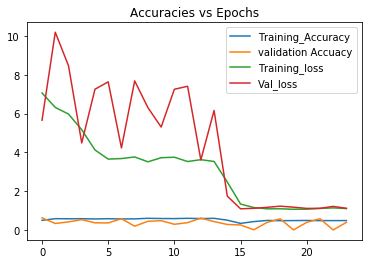

In [0]:
import matplotlib.pyplot as plt
plt.title('Accuracies vs Epochs')
plt.plot(full_model_history[0].history['acc'], label='Training_Accuracy')
plt.plot(full_model_history[0].history['val_acc'], label='validation Accuacy')
plt.plot(full_model_history[0].history['loss'], label='Training_loss')
plt.plot(full_model_history[0].history['val_loss'], label='Val_loss')
plt.legend()
plt.show()

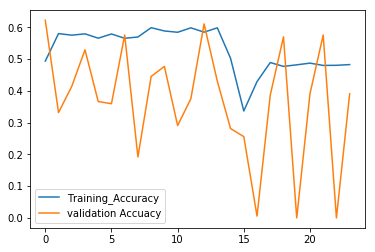

In [0]:
plt.plot(full_model_history[0].history['acc'], label='Training_Accuracy')
plt.plot(full_model_history[0].history['val_acc'], label='validation Accuacy')
plt.legend()
plt.show()